# Wine quality
[...]
Author: Albert Wildeman

CHECKS
- do not load unnecessary libraries

#JOIN DATASETS OR NOT? talk:
- A. all together, extra binary variable for red/white
- B. all separate (because requirements different for each - valid to try this first and see how similar models are)
- C. Bayesian hierarchical. Just 2 types is not much; would make more sense with say 4+

In [92]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.stats as st
from IPython.display import display

# SKLearn
from sklearn import decomposition, preprocessing, ensemble, svm, linear_model
from sklearn.model_selection import cross_val_score

#from sklearn import linear_model, ensemble, svm, neighbors, preprocessing
#from sklearn.model_selection import cross_val_score

# Graphics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

# Set random seed for reproducibility
np.random.seed(0)

# Load data

In [2]:
clrs  = ['red', 'white']
n_clrs = len(clrs)
dfs = [ pd.read_csv("data/winequality-" + clr + ".csv", sep = ';') for clr in clrs]

In [3]:
# See if the columns are identical for red and white wine
dfs[0].columns.identical(dfs[1].columns)

True

In [4]:
# Inspect the column names
dfs[0].columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
# Generate list of features
feats = dfs[0].drop('quality', axis=1).columns.values
# Get number of features
n_feats = len(feats)

In [6]:
# Determine how many missing values there are
for i_clr, clr in enumerate(clrs):
    print('Missing values in ' + clr + ' wine data: ' + str(dfs[i_clr].isnull().sum().sum()))

Missing values in red wine data: 0
Missing values in white wine data: 0


In [7]:
# None! great news.

# Log scaling
Inspect distributions of all variables, primarily for normality and outliers.

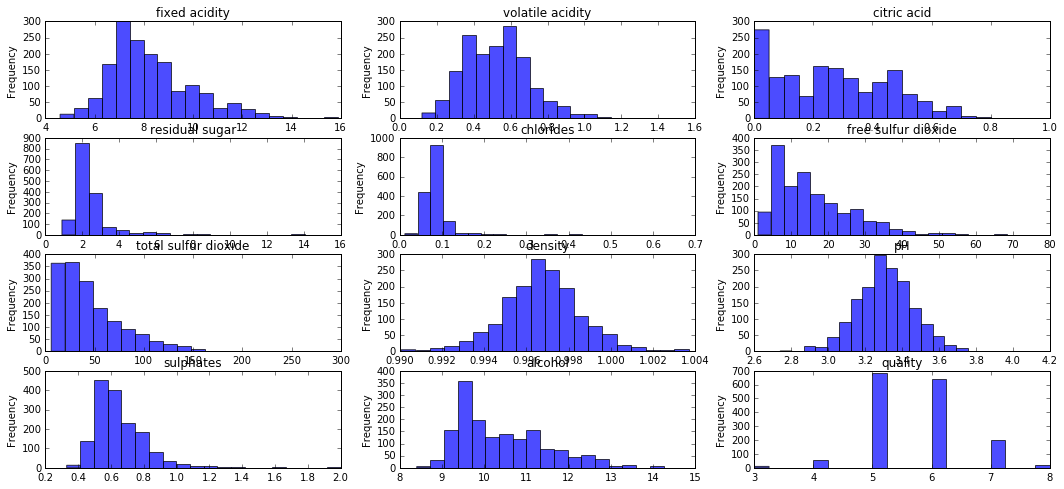

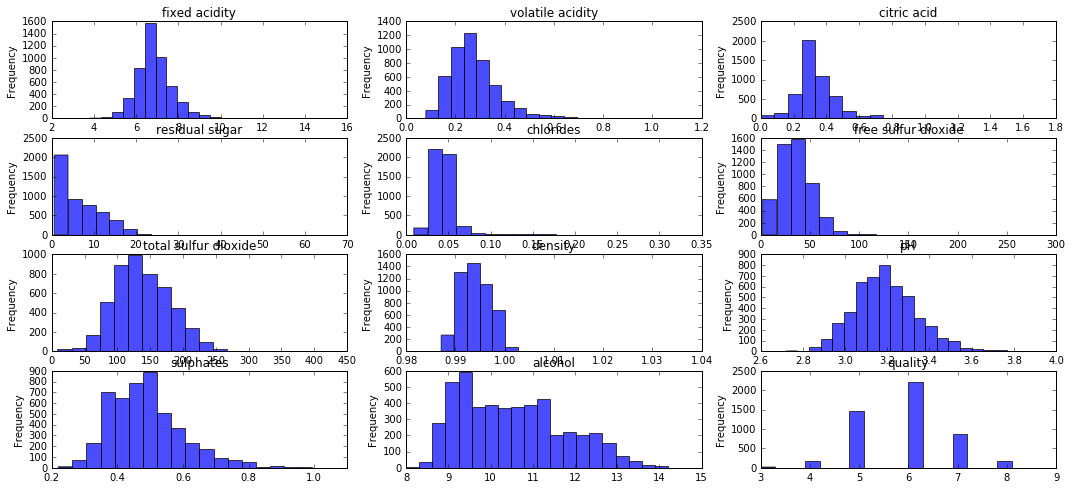

In [8]:
# Diplay histogram of sale prices
for df in dfs:
    fig = plt.figure(figsize=(18,8))
    for i_col, col in enumerate(df.columns.values):
        
        ax = plt.subplot2grid((4,3),divmod(i_col,3))
        df[col].plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
        plt.title(col)

Make remark about no (extreme) outliers

In [9]:
# Diplay histogram of sale prices
#for df in dfs:
    # automatically pick features to log-transform
    #skewed_feats = [ft for ft in feats if st.skew(df[ft].dropna())>.75]
    #display(skewed_feats)

In [10]:
# Set features to log-transform
skewed_feats = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
       'sulphates', 'alcohol']

# log transform

for df in dfs:
    df[skewed_feats] = np.log1p(df[skewed_feats])
    display(df['fixed acidity'][0])


2.1282317058492679

2.0794415416798357

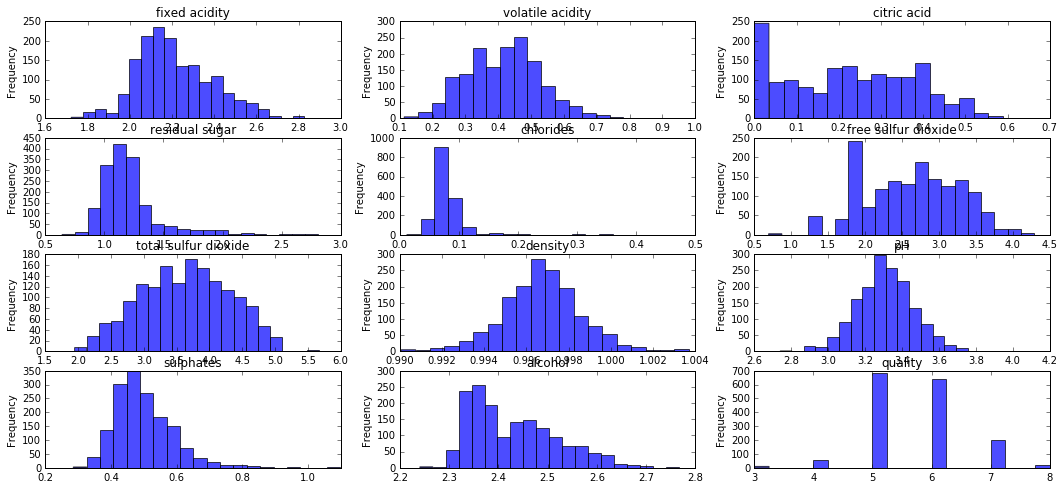

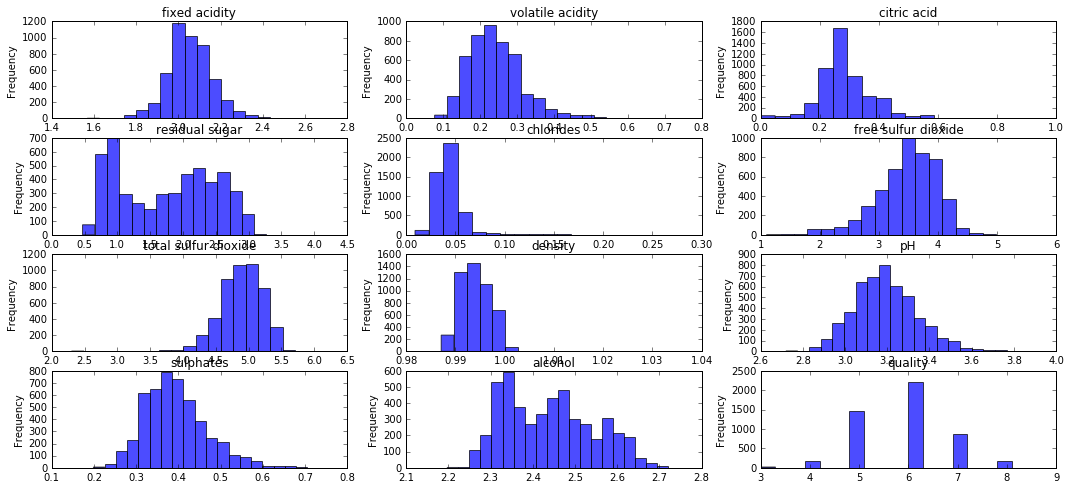

In [13]:
# Diplay histogram of sale prices
for df in dfs:
    fig = plt.figure(figsize=(18,8))
    for i_col, col in enumerate(df.columns.values):
        
        ax = plt.subplot2grid((4,3),divmod(i_col,3))
        df[col].plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
        plt.title(col)

## Normalization: mean-centering and variance scaling
One of the benefits of normalization is that it allows regularized linear models such as Lasso or Ridge Regression to penalize the various feautures evenly.

In [ ]:
for df in dfs:
    # Scale the features
    scaler_feats = preprocessing.StandardScaler()
    scaler_feats.fit(df[feats],axis=1)
    df_ready = scaler_feats.transform(df.[feats])

# PCA

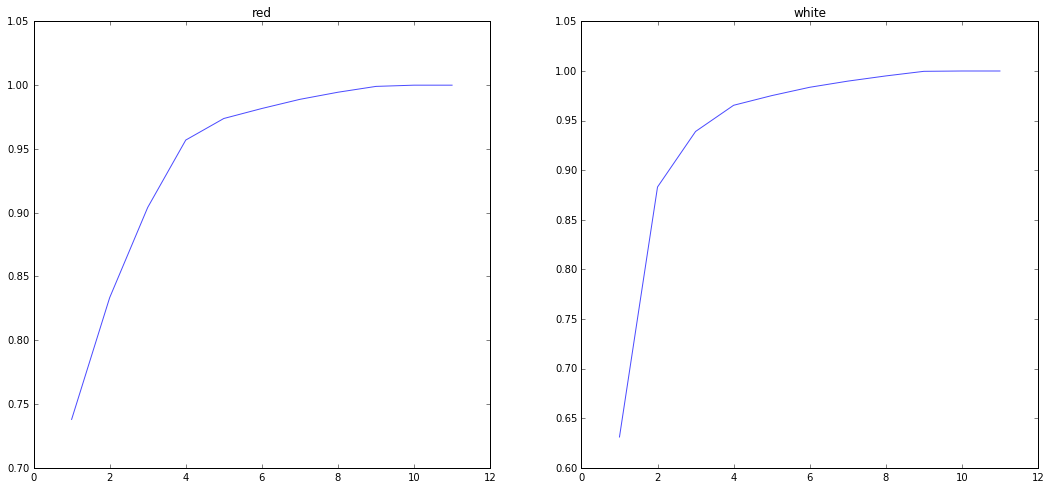

In [46]:
PCA = [None]*n_clrs
fig = plt.figure(figsize=(18,8))

for i_clr, df in enumerate(dfs):
    PCA[i_clr] = decomposition.PCA()
    PCA[i_clr].fit(df.drop('quality', axis=1))
    # Generate plot to display # of variance explained vs. # of principal components
    ax = plt.subplot2grid((1,2),(0,i_clr))
    plt.plot(np.arange(1,n_feats+1),
             pca_full[i_clr].explained_variance_ratio_.cumsum(), color='blue', alpha=0.7)    
    plt.title(clrs[i_clr])

In [ ]:
#Go with 4 PCs in both cases (lowest number to exceed 95% variance explained).
n_PC = 4

# Prep data for ML

In [52]:
# Create (PC) feature matrix for ML
X = [None]*n_clrs
for i_clr in range(n_clrs):
    PCA[i_clr].set_params(n_components=4)
    X[i_clr] = PCA[i_clr].fit_transform(dfs[i_clr].drop('quality', axis=1))

# And target vector
y = [df.quality for df in dfs]

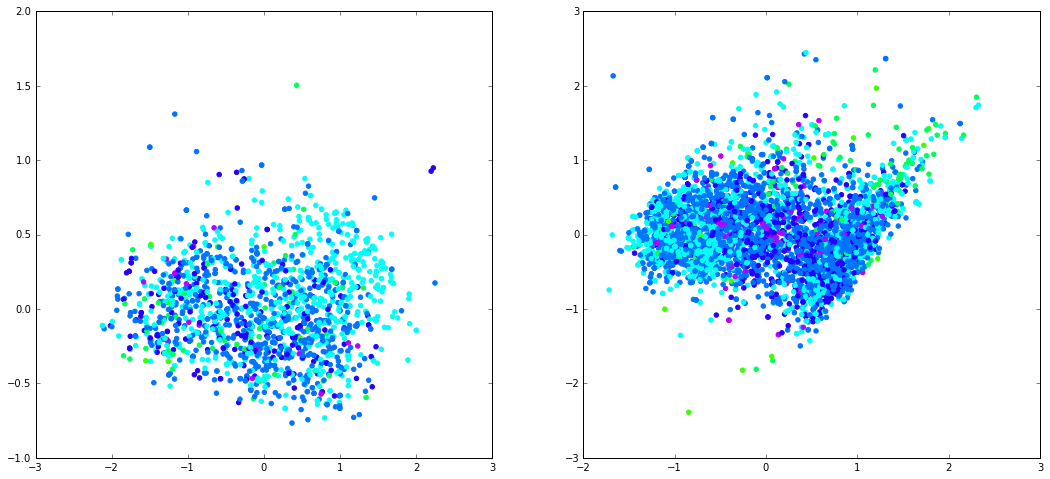

In [59]:
fig = plt.figure(figsize=(18,8))
#quality_colors = 
for i_clr in range(n_clrs):
    ax = plt.subplot2grid((1,2),(0,i_clr))
    
    colors = y[i_clr]/10.
    
    plt.scatter(X[i_clr][:,0], X[i_clr][:,1], color = matplotlib.cm.hsv(colors))
    

In [62]:
#for pca in PCA:
#    display(pca.components_)

# ML

In [72]:
# This function is used to generate CV MSEs for parameter selection, and is based on Alexandru Papiu's public notebook.
def mse_cv(model):
    mse= np.sqrt(-cross_val_score(model, X[i_clr], y[i_clr], scoring="neg_mean_squared_error", cv = 10))
    return(mse)

## Random forest

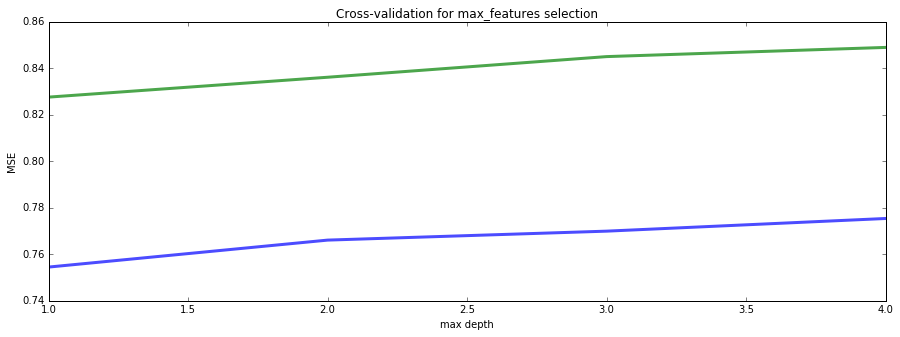

In [74]:
for i_clr in range(n_clrs):
    # Calculate CV MSE for a range of maximum tree depths
    max_feats = range(1,5)
    cv_rf = [mse_cv(ensemble.RandomForestRegressor(max_features = max_f, n_estimators=100, random_state=0)).mean() 
                for max_f in max_feats]
    cv_rf = pd.Series(cv_rf, index = max_feats)
    cv_rf.plot(title = "Cross-validation for max_features selection", alpha=0.7, lw=3)
    plt.xlabel("max depth"); plt.ylabel("MSE")

In [76]:
for i_clr in range(n_clrs):
    # Fit the model using the max_features that resulted in the lowest CV MSE.
    # Another main parameter is the number of estimators (trees) used. Numbers larger than the one used here yield take significantly
    # longer to compute and do not siginificantly imrpove the CV MSE.
    model_rf = ensemble.RandomForestRegressor(max_features=4, n_estimators=100).fit(X[i_clr], y[i_clr].ravel())
    # CV MSE
    scores = cross_val_score(model_rf, X[i_clr], y[i_clr].ravel(), cv=5, scoring="neg_mean_squared_error")
    print("CV MSE: %0.3f (+/- %0.3f)" % (-scores.mean(), scores.std() * 2))

CV MSE: 0.619 (+/- 0.163)
CV MSE: 0.727 (+/- 0.176)


## SVR

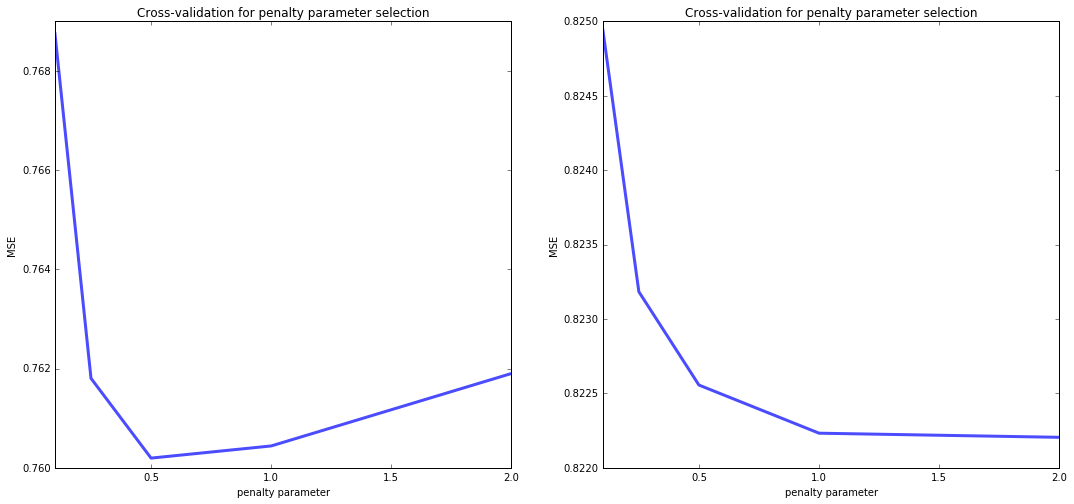

In [107]:
# I compared the performance of radial and polynomial kernels, and the latter performed better. Similarly, other degrees for the
# polynomial kernel were not as effective as the cubic option. The linear kernel option did not return a result within a reasonable
# amount of time, I am not sure why.

# Calculate CV MSE for a range of penalty parameter values
fig = plt.figure(figsize=(18,8))
for i_clr in range(n_clrs):
    cs = [.1,.25,.5,1,2]
    cv_svr = [mse_cv(svm.SVR(C = c)).mean() for c in cs]
    cv_svr = pd.Series(cv_svr, index = cs)
    ax = plt.subplot2grid((1,2),(0,i_clr))
    cv_svr.plot(title = "Cross-validation for penalty parameter selection", alpha=0.7, lw=3)
    plt.xlabel("penalty parameter"); plt.ylabel("MSE")

In [108]:
C = [0.5, 1]

for i_clr in range(n_clrs):
    # Fit the model using the value for the penalty parameter that resulted in the lowest CV MSE
    model_svr = svm.SVR(C = C[i_clr]).fit(X[i_clr], y[i_clr])
    # CV MSE
    scores = cross_val_score(model_svr, X[i_clr], y[i_clr], cv=5, scoring="neg_mean_squared_error")
    print("CV MSE: %0.3f (+/- %0.3f)" % (-scores.mean(), scores.std() * 2))

CV MSE: 0.591 (+/- 0.189)
CV MSE: 0.681 (+/- 0.174)


In [ ]:
# Confusion matrix
for i_clr in range(n_clrs):


## Gradient Boosting

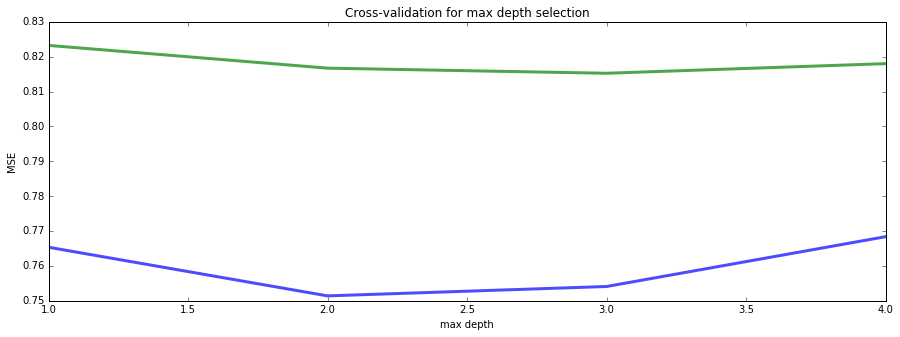

In [101]:
for i_clr in range(n_clrs):
    # Calculate CV MSE for a range of maximum tree depths
    max_depths = [1,2,3,4]
    cv_bst = [mse_cv(ensemble.GradientBoostingRegressor(max_depth = max_depth)).mean() for max_depth in max_depths]
    cv_bst = pd.Series(cv_bst, index = max_depths)
    cv_bst.plot(title = "Cross-validation for max depth selection", alpha=0.7, lw=3)
    plt.xlabel("max depth"); plt.ylabel("MSE")

In [102]:
for i_clr in range(n_clrs):
    # Fit the model using the maximum depth that resulted in the lowest MSE. As gradient boosting is fairly robust to overfitting,
    # the number of estimators is increased here. This takes significantly longer to run, and was therefore not done for the 
    # parameter selection.
    model_bst = ensemble.GradientBoostingRegressor(n_estimators=2000, max_depth = 3).fit(X[i_clr], y[i_clr])
    # CV MSE
    scores = cross_val_score(model_bst, X[i_clr], y[i_clr], cv=5, scoring="neg_mean_squared_error")
    print("CV MSE: %0.3f (+/- %0.3f)" % (-scores.mean(), scores.std() * 2))

CV MSE: 0.745 (+/- 0.186)
CV MSE: 0.838 (+/- 0.155)


## Lasso

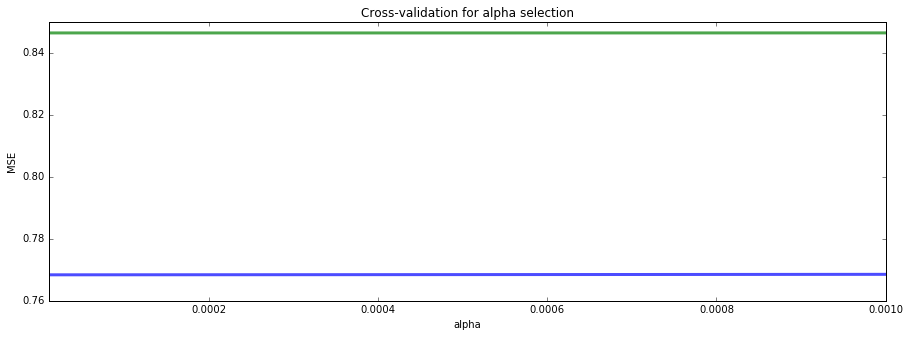

In [103]:
for i_clr in range(n_clrs):
    # Calculate CV MSE for a range of alpha values
    alphas = [1e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 7.5e-4, 1e-3]
    cv_lasso = [mse_cv(linear_model.Lasso(alpha = alpha)).mean() for alpha in alphas]
    cv_lasso = pd.Series(cv_lasso, index = alphas)
    cv_lasso.plot(title = "Cross-validation for alpha selection", alpha=0.7, lw=3)
    plt.xlabel("alpha"); plt.ylabel("MSE")

In [104]:
for i_clr in range(n_clrs):
    # Fit the model using the alpha that resulted in the lowest CV MSE
    model_lasso = linear_model.Lasso(alpha = 7.5e-3).fit(X[i_clr], y[i_clr])
    # CV MSE
    scores = cross_val_score(model_lasso, X[i_clr], y[i_clr], cv=5, scoring="neg_mean_squared_error")
    print("CV MSE: %0.3f (+/- %0.3f)" % (-scores.mean(), scores.std() * 2))

CV MSE: 0.603 (+/- 0.135)
CV MSE: 0.727 (+/- 0.175)
